In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [37]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Load data
file_path = "./TrainDataset2024.xls"
df = pd.read_excel(file_path)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.2+ KB
None
       pCR (outcome)  RelapseFreeSurvival (outcome)         Age          ER  \
count     400.000000                     400.000000  400.000000  400.000000   
mean       12.697500                      56.000208   51.804674    0.547500   
std       111.107417                      27.137584   10.948522    0.498362   
min         0.000000                       0.000000   23.000000    0.000000   
25%         0.000000                      38.000000   44.516769    0.000000   
50%         0.000000                      55.000000   51.019507    1.000000   
75%         0.000000                      73.000000   60.000000    1.000000   
max       999.000000                     144.000000   79.603012    1.000000   

              PgR        HER2  TrippleNegative  ChemoGrade  Proliferation  \
count  400.0000

In [38]:
# Step 1: missing values
# replace 999 with NaN
df.replace(999, np.nan, inplace=True)
print(df.isnull().sum())

# Imputation of Gene
print(f"Ratio of missing value in Gene is {df['Gene'].isnull().sum() / df['Gene'].count()}")
df['Gene'] = df['Gene'].fillna(-1)

# Drop pCR
df.drop(columns="pCR (outcome)",inplace=True)

# Categorical imputation
categorical_features = ['ER', 'PgR','HER2', 'TrippleNegative', 'ChemoGrade','Proliferation','HistologyType','LNStatus','TumourStage', 'Gene']
imputer_cat = SimpleImputer(strategy='most_frequent')
df[categorical_features] = imputer_cat.fit_transform(df[categorical_features])

# Numerical Imputation
numerical_features = [col for col in df.columns if col not in categorical_features + ['ID', 'RelapseFreeSurvival (outcome)']]
imputer_num = KNNImputer(n_neighbors=5)
df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

ID                               0
pCR (outcome)                    5
RelapseFreeSurvival (outcome)    0
Age                              0
ER                               0
                                ..
original_ngtdm_Busyness          0
original_ngtdm_Coarseness        0
original_ngtdm_Complexity        0
original_ngtdm_Contrast          0
original_ngtdm_Strength          0
Length: 121, dtype: int64
Ratio of missing value in Gene is 0.28205128205128205


In [39]:
from sklearn.impute import KNNImputer

# Step 2: 异常值检测和处理
# 使用箱线图法检测异常值（示例以 Tumour Proliferation 为例）
for col in numerical_features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # 替换异常值为边界值
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

In [40]:
# Step 3: Data Standardization
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

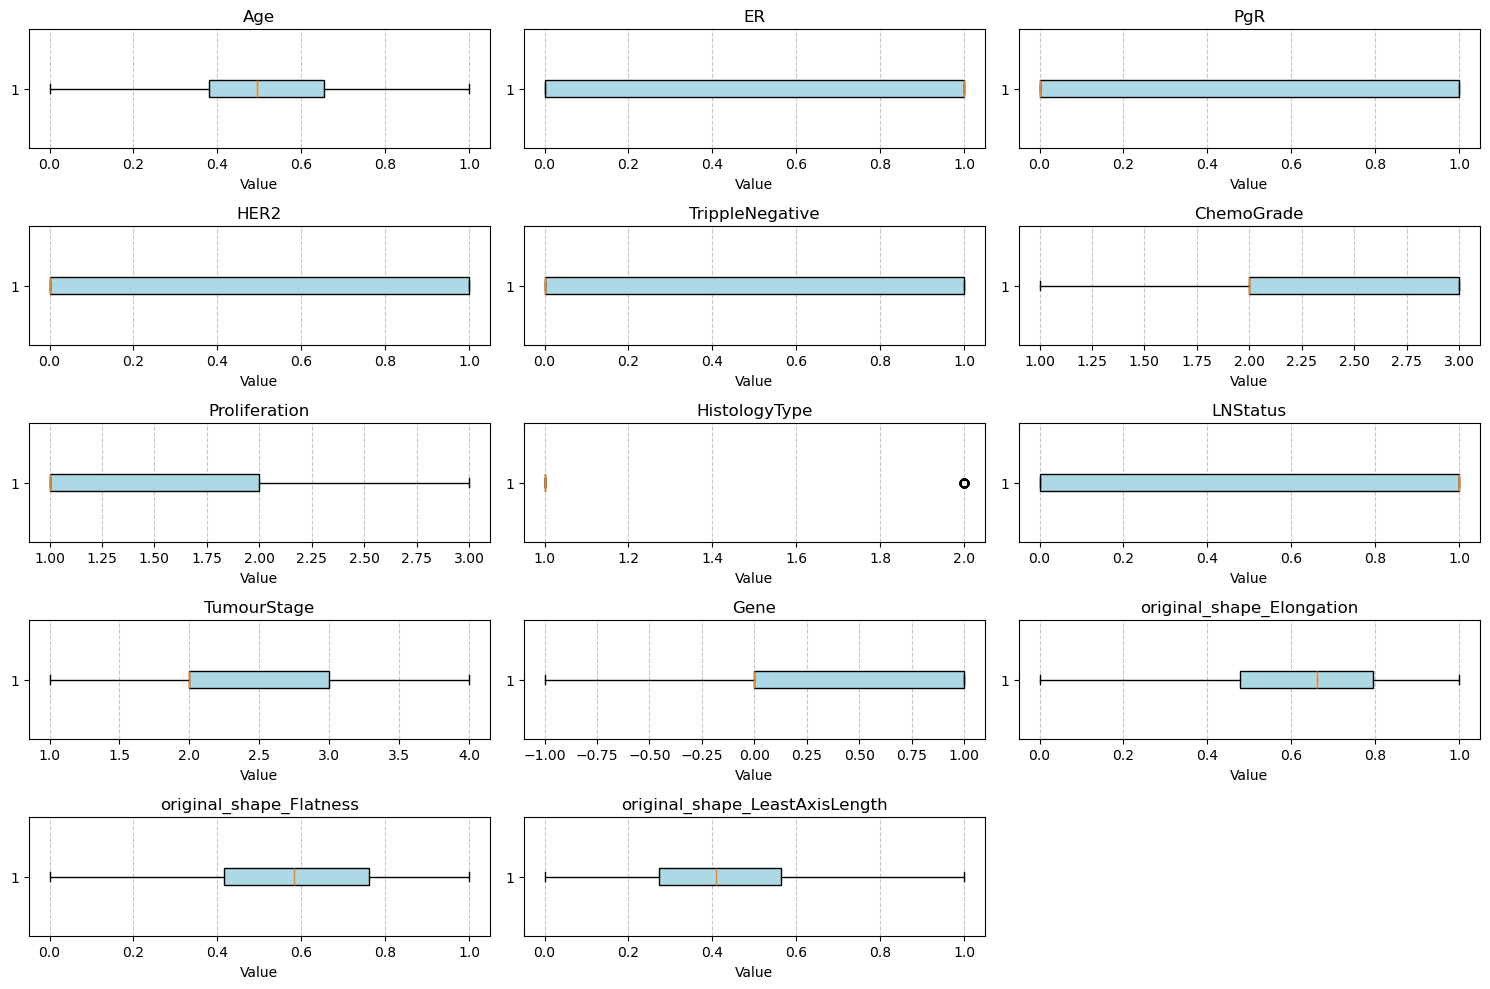

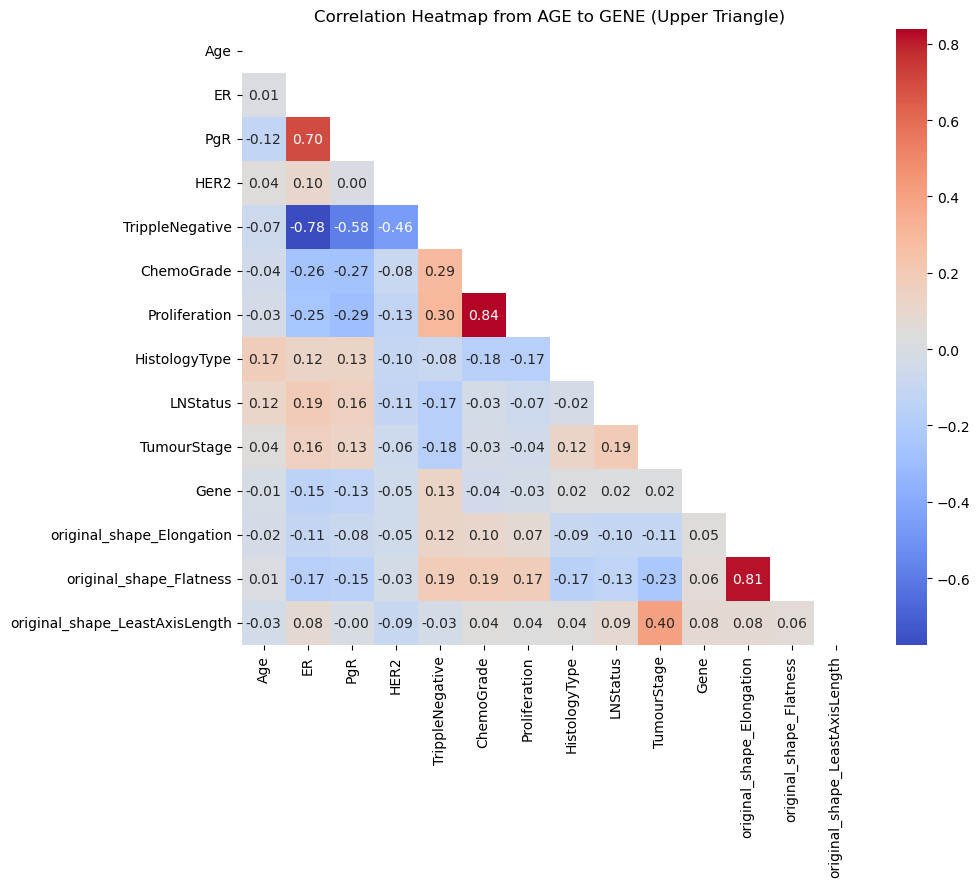

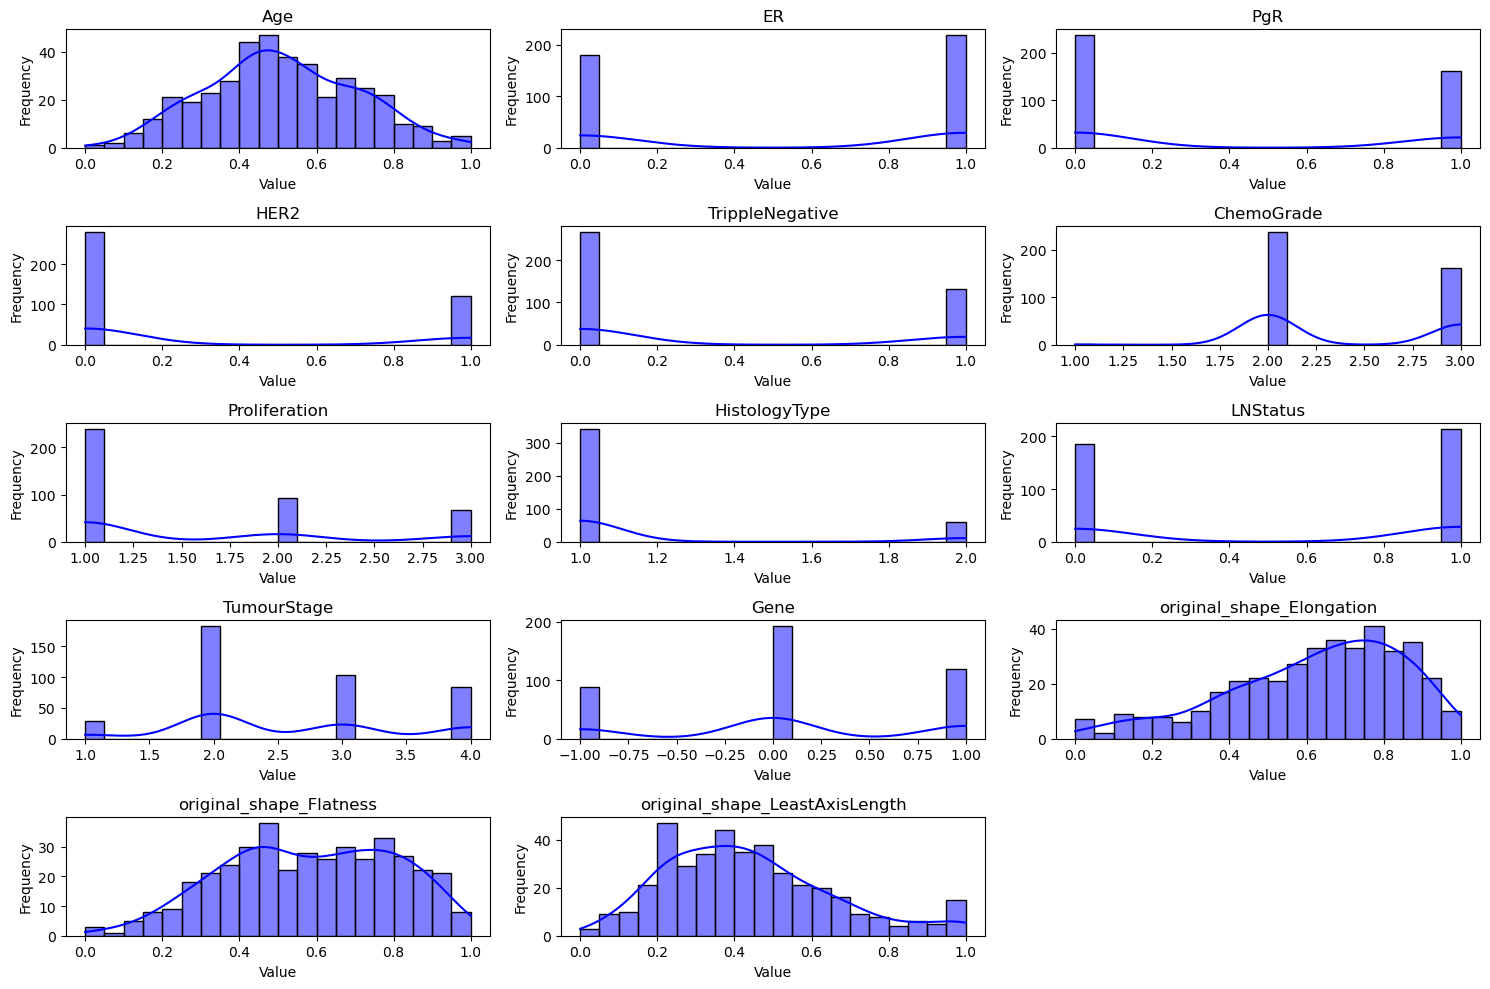

In [41]:
# from AGE to GENE
selected_columns = df.loc[:, 'Age':'original_shape_LeastAxisLength']

# Step 1: 绘制箱线图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    plt.boxplot(selected_columns[col].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(col)
    plt.xlabel('Value')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Step 2: 绘制相关性热图
# 计算相关性矩阵
corr_matrix = selected_columns.corr()
# 使用 Seaborn 绘制热成像分布图
plt.figure(figsize=(10, 8))
# 创建掩码
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# 使用 Seaborn 绘制热成像分布图（仅上三角）
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Heatmap from AGE to GENE (Upper Triangle)")
plt.show()

# Step 3: 绘制直方图
plt.figure(figsize=(15, 10))
for i, col in enumerate(selected_columns.columns):
    plt.subplot((len(selected_columns.columns) + 2) // 3, 3, i + 1)  # 动态布局
    sns.histplot(selected_columns[col], kde=True, color='blue', bins=20)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [42]:
# Step 4: 数据划分
# 提取特征和目标变量
X = df.drop(columns=['ID', 'RelapseFreeSurvival (outcome)']) 
y = df['RelapseFreeSurvival (outcome)']

# 按 8:2 分层划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,root_mean_squared_error,r2_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
import numpy as np

def evaluate_model(model,y_val,y_pred):
    print(model)
    print(f"Mean Squared Error(MSE): {mean_squared_error(y_val, y_pred)}")
    print(f"Mean Absolute Error(MAE): {mean_absolute_error(y_val, y_pred)}")
    print(f"R Squared(R²): {r2_score(y_val, y_pred)}")
    print(f"Root Mean Squared Error(RMSE): {root_mean_squared_error(y_val, y_pred)}\n")

    
# Performance evaluation functios
def compute_bias_variance(model, X, y, cv=5):
    # Initialize arrays to store predictions and targets
    all_predictions = np.zeros(len(y))
    fold_predictions = []
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train the model and predict on the test fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Store predictions in their correct positions
        all_predictions[test_idx] = predictions
        fold_predictions.append(predictions)

    # Convert fold predictions to a numpy array
    fold_predictions = np.array([np.concatenate(fold_predictions)])

    # Compute average predictions
    avg_predictions = np.mean(fold_predictions, axis=0)

    # Compute Bias and Variance
    bias = np.mean((y - avg_predictions) ** 2)
    variance = np.mean((fold_predictions - avg_predictions) ** 2)
    return bias, variance   

In [44]:
# Step 6: Build Baseline Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Model 1: LogisticRegression
baseline_lr = LinearRegression()
baseline_lr.fit(X_train, y_train)
y_pred = baseline_lr.predict(X_val)
evaluate_model(baseline_lr,y_val,y_pred)

# Model 2: RandomForestRegressor
baseline_rf = RandomForestRegressor(random_state=42)
baseline_rf.fit(X_train, y_train)
y_pred = baseline_rf.predict(X_val)
evaluate_model(baseline_rf,y_val,y_pred)

LinearRegression()
Mean Squared Error(MSE): 1692.8770656396232
Mean Absolute Error(MAE): 29.683456278344
R Squared(R²): -1.1212466186004604
Root Mean Squared Error(RMSE): 41.144587318863984

RandomForestRegressor(random_state=42)
Mean Squared Error(MSE): 845.0951060503473
Mean Absolute Error(MAE): 22.89540625
R Squared(R²): -0.05893993869411562
Root Mean Squared Error(RMSE): 29.07051953526712



In [45]:
# Feature importances
importances = baseline_rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                              Feature  Importance
36          original_firstorder_Range    0.040370
42       original_firstorder_Variance    0.036901
110        original_glszm_ZoneEntropy    0.034975
26   original_firstorder_90Percentile    0.032862
30       original_firstorder_Kurtosis    0.031178
..                                ...         ...
51   original_glcm_DifferenceVariance    0.000819
49    original_glcm_DifferenceAverage    0.000801
47             original_glcm_Contrast    0.000711
116           original_ngtdm_Contrast    0.000690
65           original_glcm_SumEntropy    0.000644

[118 rows x 2 columns]


<Axes: >

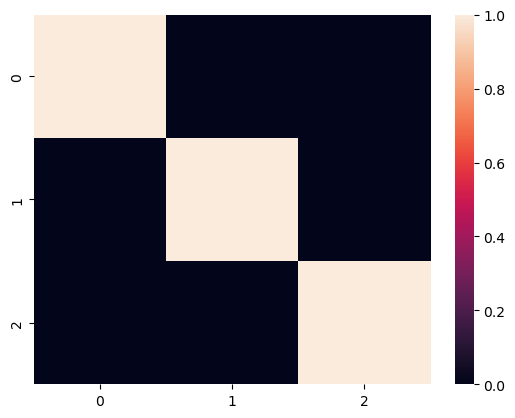

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
X_train_pca= pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_train_pca,X_val_pca = pd.DataFrame(X_train_pca),pd.DataFrame(X_val_pca)
X_train_pca.head()
sns.heatmap(X_train_pca.corr())

In [47]:
# Model 1: LogisticRegression
lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_val_pca)
evaluate_model(lr,y_val,y_pred)

LinearRegression()
Mean Squared Error(MSE): 819.5152598291031
Mean Absolute Error(MAE): 21.969268870948213
R Squared(R²): -0.026887308646444508
Root Mean Squared Error(RMSE): 28.627176944803747



In [48]:
# Model 1: RandomForestClassifier
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(X_val_pca)
evaluate_model(rf,y_val,y_pred)

RandomForestRegressor(random_state=42)
Mean Squared Error(MSE): 898.832145407986
Mean Absolute Error(MAE): 23.27009375
R Squared(R²): -0.12627472356694502
Root Mean Squared Error(RMSE): 29.980529438420294

